In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_context('talk')
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import os
cwd = os.getcwd().split('\\')
local_repo_path = '/'.join(cwd[:-1])
raw_data_path = local_repo_path + r"\\data\\raw"
processed_data_path = local_repo_path + r"\\data\\processed"
feature_path = local_repo_path + r"\\data\\features"

In [2]:
train = pd.read_csv(processed_data_path + r"/train_dataset.csv", index_col = 0)
test = pd.read_csv(raw_data_path + r"/dengue_features_test.csv", index_col = None)
combined = pd.read_csv(processed_data_path + r"/combined_train_test_dataset.csv", index_col = 0)

In [3]:
train['quarter'] = pd.to_datetime(train['week_start_date']).map(lambda x: x.quarter)
test['quarter'] = pd.to_datetime(test['week_start_date']).map(lambda x: x.quarter)
train['month'] = pd.to_datetime(train['week_start_date']).map(lambda x: x.month)
test['month'] = pd.to_datetime(test['week_start_date']).map(lambda x: x.month)

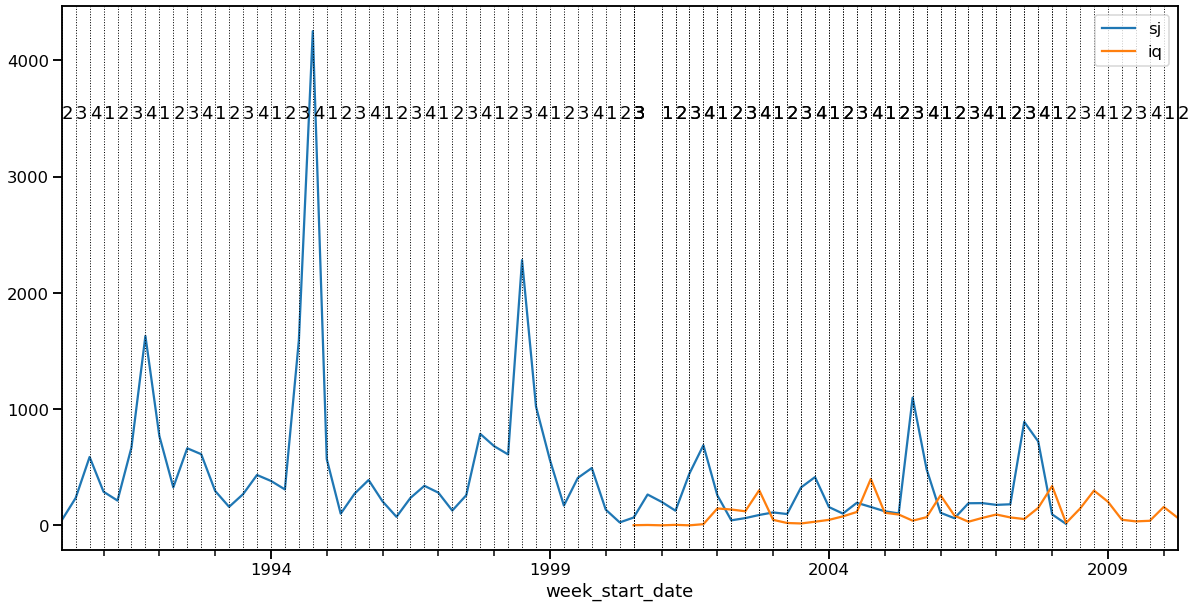

In [4]:
# Generating quarterly total_cases for both cities

fig, ax = plt.subplots(figsize = (20,10))
train[train['city'] == 'sj'][['week_start_date', 'total_cases']].set_index(pd.DatetimeIndex(train[train['city'] == 'sj']['week_start_date'])).groupby(pd.Grouper(freq='Q')).sum().plot(ax = ax)
train[train['city'] == 'iq'][['week_start_date', 'total_cases']].set_index(pd.DatetimeIndex(train[train['city'] == 'iq']['week_start_date'])).groupby(pd.Grouper(freq='Q')).sum().plot(ax = ax)
ax.legend(labels = ['sj', 'iq'])

for i, d in enumerate(train['weekofyear']):
    if np.mod(d, 13) == 0 or d == 53:
        ax.axvline(train['week_start_date'].values[i], color = 'black', linewidth = 1, linestyle = 'dotted')
        ax.text(train['week_start_date'].values[i], 3500, train['quarter'][i])

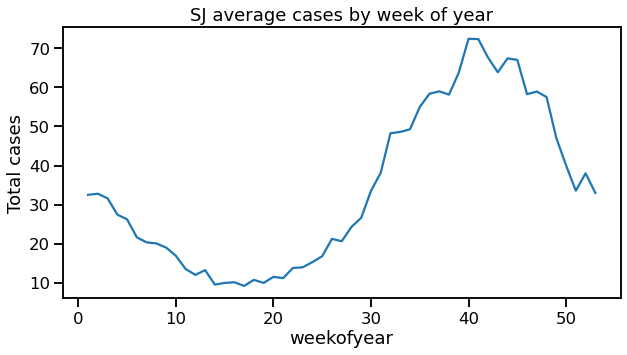

In [5]:
# Average Cases by week SJ
fig, ax = plt.subplots(figsize = (10,5));
train[train['city'] == 'sj'][['weekofyear', 'total_cases']].groupby('weekofyear').agg(['mean']).plot(ax = ax);
ax.set_ylabel('Total cases');
ax.legend().set_visible(False);
ax.set_title('SJ average cases by week of year');

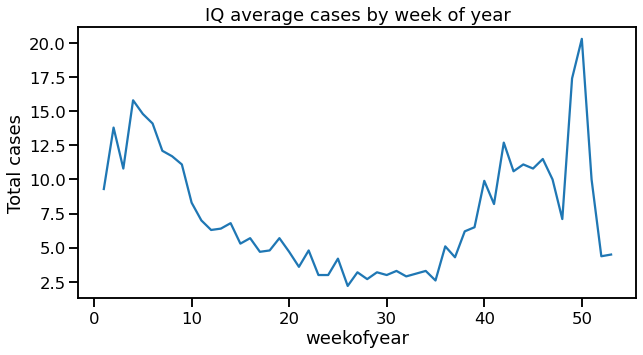

In [6]:
# Average Cases by week IQ
fig, ax = plt.subplots(figsize = (10,5));
train[train['city'] == 'iq'][['weekofyear', 'total_cases']].groupby('weekofyear').agg(['mean']).plot(ax = ax);
ax.set_ylabel('Total cases');
ax.legend().set_visible(False);
ax.set_title('IQ average cases by week of year');

In [7]:
# Creating weekly cases

weekly_cases_sj = train[train['city'] == 'sj'][['weekofyear', 'total_cases']].groupby('weekofyear').mean()
pfit6 = np.polyfit(weekly_cases_sj.index, weekly_cases_sj['total_cases'], deg = 6)  # 6D polynomial is best suited for SJ
p6 = np.poly1d(pfit6)

weekly_cases_iq = train[train['city'] == 'iq'][['weekofyear', 'total_cases']].groupby('weekofyear').mean()
pfit2 = np.polyfit(weekly_cases_iq.index[:-2], weekly_cases_iq['total_cases'][:-2], deg = 2)
p2 = np.poly1d(pfit2)

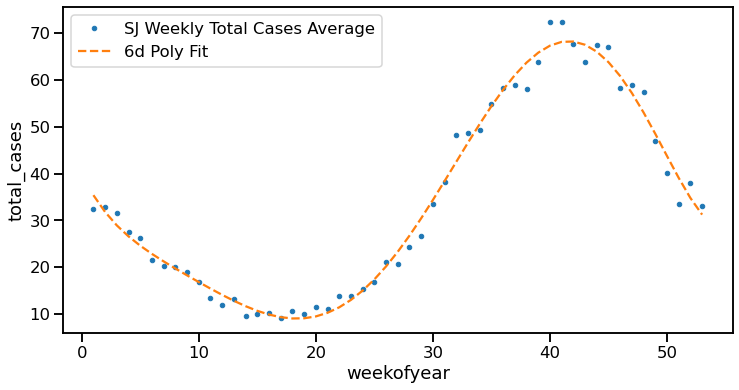

In [8]:
fig, ax = plt.subplots(figsize = (12,6));
ax.plot(weekly_cases_sj.index, weekly_cases_sj['total_cases'], '.', label = 'SJ Weekly Total Cases Average');
ax.plot(weekly_cases_sj.index, p6(weekly_cases_sj.index), '--', label = '6d Poly Fit');
ax.set_xlabel('weekofyear')
ax.set_ylabel('total_cases')
ax.legend()

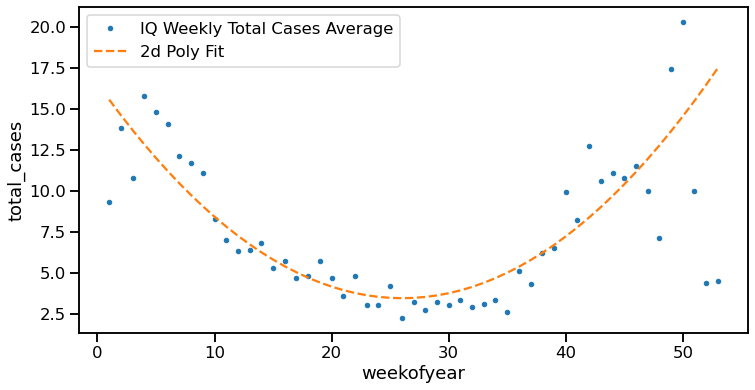

In [9]:
fig, ax = plt.subplots(figsize = (12,6));
ax.plot(weekly_cases_iq.index, weekly_cases_iq['total_cases'], '.', label = 'IQ Weekly Total Cases Average');
ax.plot(weekly_cases_iq.index, p2(weekly_cases_iq.index), '--', label = '2d Poly Fit');
ax.set_xlabel('weekofyear')
ax.set_ylabel('total_cases')
ax.legend();

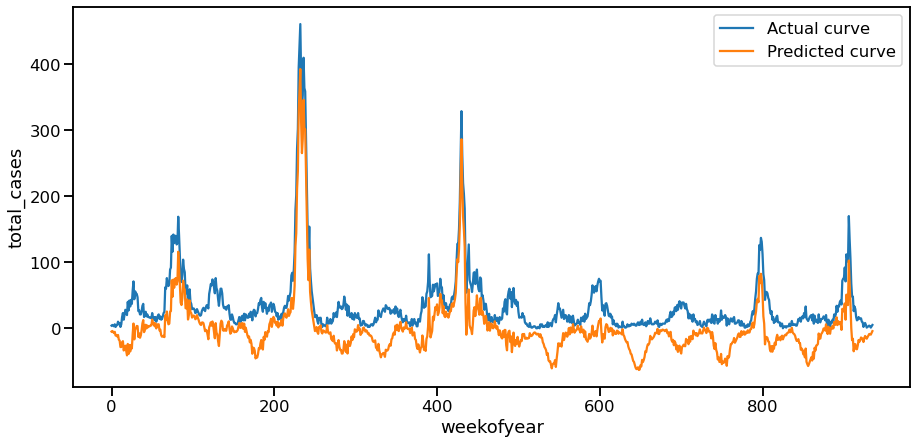

In [10]:
fig, ax = plt.subplots(figsize = (15,7));
ax.plot(train[train['city'] == 'sj'].index, train[train['city'] == 'sj']['total_cases'], label = 'Actual curve')
ax.plot(train[train['city'] == 'sj'].index, train[train['city'] == 'sj']['total_cases'] - p6(train[train['city'] == 'sj']['weekofyear']), label = 'Predicted curve')
ax.set_xlabel('weekofyear')
ax.set_ylabel('total_cases')
ax.legend()

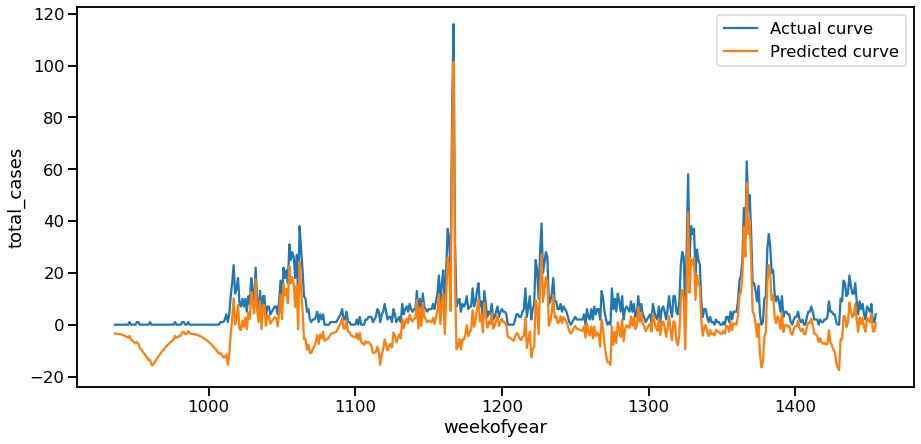

In [11]:
fig, ax = plt.subplots(figsize = (15,7));
ax.plot(train[train['city'] == 'iq'].index, train[train['city'] == 'iq']['total_cases'], label = 'Actual curve')
ax.plot(train[train['city'] == 'iq'].index, train[train['city'] == 'iq']['total_cases'] - p2(train[train['city'] == 'iq']['weekofyear']), label = 'Predicted curve')
ax.set_xlabel('weekofyear')
ax.set_ylabel('total_cases')
ax.legend()

In [12]:
# Appending the polynomial values to train dataset
sj_poly_train = p6(weekly_cases_sj.index)
iq_poly_train = p2(weekly_cases_iq.index)
sj_poly_test = p6(weekly_cases_sj.index)
iq_poly_test = p2(weekly_cases_iq.index)
train['poly_fit'] = 0
for i in (weekly_cases_sj.index):
    mask = (train.city == 'sj') & (train.weekofyear == i)
    train.loc[mask, 'poly_fit'] = sj_poly_train[i-1]
    mask = (test.city == 'sj') & (test.weekofyear == i)
    test.loc[mask, 'poly_fit'] = sj_poly_test[i-1]
    mask = (train.city == 'iq') & (train.weekofyear == i)
    train.loc[mask, 'poly_fit'] = iq_poly_train[i-1]
    mask = (test.city == 'iq') & (test.weekofyear == i)
    test.loc[mask, 'poly_fit'] = iq_poly_test[i-1]

train_sj = train[train['city'] == 'sj']
test_sj = test[test['city']=='sj']
train_iq = train[train['city'] == 'iq'].reset_index().drop('index', axis = 1)
test_iq = test[test['city'] == 'iq'].reset_index().drop('index', axis = 1)

In [13]:
# Creating features for modeling
numeric_cols = combined.select_dtypes(include=[np.number]).drop(['year', 'weekofyear'], axis = 1).columns.tolist()
numeric_cols
best_raw_features = ['reanalysis_specific_humidity_g_per_kg', 'reanalysis_dew_point_temp_k', 'station_avg_temp_c', 'station_min_temp_c', 'poly_fit']
categorical_cols = None

In [14]:
from SKL_search import *
from sklearn.preprocessing import OneHotEncoder
def feature_pipeline(df_train, df_test, numeric_cols, categorical_cols = ['month', 'quarter'], num_pca = 3):
    
    #Create pipeline for numerical features
            # Interpolate > Impute > add features > scale
        
    df_train.loc[:,numeric_cols].interpolate(inplace = True)
    df_test.loc[:,numeric_cols].interpolate(inplace = True)
    num_feature_pipeline = Pipeline([
                                    ("imputer", SimpleImputer(strategy="mean")),
                                    ('features', FeatureUnion([
                                                               ('poly', PolynomialFeatures(degree = 2, interaction_only = False, include_bias = True))])), 
                                    ("scaler", RobustScaler())])
    
    #Fit numerical pipeline to training data
    num_train_pipe_fit = num_feature_pipeline.fit(df_train[numeric_cols], df_train['total_cases'])
    
    #Handle categorical features by one hot encoding

    
    if categorical_cols != None:
        enc = OneHotEncoder()
        encfit = enc.fit(df_train[categorical_cols])
        #Construct training features
        num_features_train = num_train_pipe_fit.transform(df_train[numeric_cols])
        cat_features_train = encfit.transform(df_train[categorical_cols]).toarray()
        train_feature_df = pd.DataFrame(np.concatenate((num_features_train, cat_features_train), axis = 1))
        train_feature_df['total_cases'] = df_train['total_cases']

        #Construct test features (with additional columns for submission format) 
        num_features_test = num_train_pipe_fit.transform(df_test[numeric_cols])
        cat_features_test = encfit.transform(df_test[categorical_cols]).toarray()
        test_feature_df = pd.DataFrame(np.concatenate((num_features_test, cat_features_test), axis = 1))
        test_feature_df['city'] = df_test['city']
        test_feature_df['year'] = df_test['year']
        test_feature_df['weekofyear'] = df_test['weekofyear']
    
    else:
        #Construct training features
        num_features_train = num_train_pipe_fit.transform(df_train[numeric_cols])
        train_feature_df = pd.DataFrame(num_features_train)
        train_feature_df['total_cases'] = df_train['total_cases']

        #Construct test features (with additional columns for submission format) 
        num_features_test = num_train_pipe_fit.transform(df_test[numeric_cols])
        test_feature_df = pd.DataFrame(num_features_test)
        test_feature_df['city'] = df_test['city']
        test_feature_df['year'] = df_test['year']
        test_feature_df['weekofyear'] = df_test['weekofyear']
    
    return(train_feature_df, test_feature_df)
    

In [15]:
numeric_cols = best_raw_features

iq_feature_train, iq_feature_test = feature_pipeline(train_iq, test_iq, numeric_cols, categorical_cols)
sj_feature_train, sj_feature_test = feature_pipeline(train_sj, test_sj, numeric_cols, categorical_cols)

In [16]:
output_feature_fname = '2degree_poly'

In [17]:
sj_feature_train.to_csv(feature_path + r'\\sj_train_' + output_feature_fname + '.csv')
sj_feature_test.to_csv(feature_path + r'\\sj_test_' + output_feature_fname + '.csv')
iq_feature_train.to_csv(feature_path + r'\\iq_train_' + output_feature_fname + '.csv')
iq_feature_test.to_csv(feature_path + r'\\iq_test_' + output_feature_fname + '.csv')